In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from matplotlib import rcParams
import matplotlib.patheffects as PathEffects


In [2]:
dataset_map = {
    "akiec": "Actinic keratoses",
    "bcc": "Basal cell carcinoma",
    # "bkl": "Benign keratosis-like lesions",
    "bkl": "Benign keratosis",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
    "vasc": "Vascular lesions",
    "Crescent": "Crescent",
    "Hypercellularity": "Hypercellularity",
    "Membranous": "Membranous",
    "Normal": "Normal",
    "Podocytopathy": "ECDC",
    "Sclerosis": "Sclerosis",
    "Clear_Cell": "Clear Cell",
    "Endometri": "Endometri",
    "Mucinous": "Mucinous",
    "Non_Cancerous": "Non Cancerous",
    "Serous": "Serous"
}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from sklearn.decomposition import PCA

def plot_embedding_space(
    db_embeddings,
    db_labels_bin,
    class_mapping,
    query_embeddings=None,
    dim=2,
    save_path="embedding_plot.pdf"
):
    """
    Plots 2D or 3D embeddings using UMAP.

    Args:
        db_embeddings (np.ndarray): Embeddings for the database.
        db_labels_bin (np.ndarray): Integer labels.
        class_mapping (dict): Mapping from int to class string.
        query_embeddings (np.ndarray, optional): Embeddings for query points. Default is None.
        dim (int): Dimension for projection (2 or 3). Default is 2.
        save_path (str): Where to save the resulting plot.
    """
    assert dim in [2, 3], "dim must be 2 or 3"

    db_labels = np.array([class_mapping[i] for i in db_labels_bin])

    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        n_components=dim,
        random_state=42
    )
    embedding_proj = reducer.fit_transform(db_embeddings)

    if query_embeddings is not None:
        query_proj = reducer.transform(query_embeddings)
    else:
        query_proj = None

    # Plotting
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d" if dim == 3 else None)

    unique_classes = np.unique(db_labels)
    cmap = plt.cm.get_cmap("tab10", len(unique_classes))

    for i, cls in enumerate(unique_classes):
        idx = db_labels == cls
        coords = embedding_proj[idx]
        color = cmap(i)

        if dim == 3:
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       label=cls, s=30, alpha=0.7, color=color, edgecolor='k', linewidth=0.3)
        else:
            ax.scatter(coords[:, 0], coords[:, 1],
                       label=cls, s=30, alpha=0.7, color=color, edgecolor='k', linewidth=0.3)

    # Query overlay
    if query_proj is not None:
        if dim == 3:
            ax.scatter(query_proj[:, 0], query_proj[:, 1], query_proj[:, 2],
                       s=60, c='red', marker='X', label='Query', edgecolor='black', linewidth=0.6)
        else:
            ax.scatter(query_proj[:, 0], query_proj[:, 1],
                       s=60, c='red', marker='X', label='Query', edgecolor='black', linewidth=0.6)

    ax.set_title(f"UMAP projection of embeddings ({dim}D)", fontsize=13)
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    if dim == 2:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    ax.grid(False)
    ax.set_box_aspect([1]*dim)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", transparent=True, dpi=300)
    plt.show()

def plot_embedding_pca(
    db_embeddings,
    db_labels_bin,
    class_mapping,
    query_embeddings=None,
    dim=2,
    save_path="embedding_pca_plot.pdf"
):
    """
    Plots a stylized 2D or 3D PCA projection of embeddings for scientific papers.

    Args:
        db_embeddings (np.ndarray): Embeddings for the database.
        db_labels_bin (np.ndarray): Integer labels.
        class_mapping (dict): Mapping from int to class string.
        query_embeddings (np.ndarray, optional): Embeddings for query points.
        dim (int): Dimension for projection (2 or 3).
        save_path (str): Where to save the resulting plot.
    """
    assert dim in [2, 3], "dim must be 2 or 3"

    db_labels = np.array([class_mapping[i] for i in db_labels_bin])

    # PCA projection
    if query_embeddings is not None:
        combined = np.vstack([db_embeddings, query_embeddings])
        pca = PCA(n_components=dim, random_state=42)
        proj = pca.fit_transform(combined)
        db_proj = proj[:len(db_embeddings)]
        query_proj = proj[len(db_embeddings):]
    else:
        pca = PCA(n_components=dim, random_state=42)
        db_proj = pca.fit_transform(db_embeddings)
        query_proj = None

    # Plotting
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d" if dim == 3 else None)
    cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))

    for i, cls in enumerate(np.unique(db_labels)):
        idx = db_labels == cls
        coords = db_proj[idx]
        color = cmap(i)

        if dim == 3:
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       s=30, alpha=0.75, color=color, label=dataset_map[cls] if cls in dataset_map else cls,
                       edgecolor='k', linewidth=0.3)
        else:
            ax.scatter(coords[:, 0], coords[:, 1],
                       s=30, alpha=0.75, color=color, label=dataset_map[cls] if cls in dataset_map else cls,
                       edgecolor='k', linewidth=0.3)

    # Optional query overlay
    if query_proj is not None:
        if dim == 3:
            ax.scatter(query_proj[:, 0], query_proj[:, 1], query_proj[:, 2],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)
        else:
            ax.scatter(query_proj[:, 0], query_proj[:, 1],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)

    # Axis labels and formatting
    if dim == 2:

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, linestyle='--', alpha=0.2)
    else:

        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.grid(False)
        ax.set_box_aspect([1, 1, 1])

    # ax.set_title(f"PCA projection of embeddings ({dim}D)", fontsize=13)
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", transparent=True, dpi=50)
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa

def plot_embedding_pca(
    db_embeddings,
    db_labels_bin,
    class_mapping,
    query_embeddings=None,
    dim=2,
    save_path="embedding_pca_plot.pdf",
    show_legend=True,
    legend_fontsize=12
):
    assert dim in [2, 3], "dim must be 2 or 3"
    db_labels = np.array([class_mapping[i] for i in db_labels_bin])

    # Combine for joint PCA fit
    if query_embeddings is not None:
        combined = np.vstack([db_embeddings, query_embeddings])
        pca = PCA(n_components=dim, random_state=42)
        proj = pca.fit_transform(combined)
        db_proj = proj[:len(db_embeddings)]
        query_proj = proj[len(db_embeddings):]
    else:
        pca = PCA(n_components=dim, random_state=42)
        db_proj = pca.fit_transform(db_embeddings)
        query_proj = None

    # Plot setup
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d" if dim == 3 else None)
    cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))

    for i, cls in enumerate(np.unique(db_labels)):
        idx = db_labels == cls
        coords = db_proj[idx]
        color = cmap(i)
        if dim == 3:
            cls_plot = cls.replace("_", " ")  # Replace spaces for better legend labels
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       s=30, alpha=0.75, color=color, label=dataset_map[cls] if cls in dataset_map else cls,
                       edgecolor='k', linewidth=0.3)
        else:
            ax.scatter(coords[:, 0], coords[:, 1],
                       s=30, alpha=0.75, color=color, label=dataset_map[cls] if cls in dataset_map else cls,
                       edgecolor='k', linewidth=0.3)

    # Optional query overlay
    if query_proj is not None:
        if dim == 3:
            ax.scatter(query_proj[:, 0], query_proj[:, 1], query_proj[:, 2],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)
        else:
            ax.scatter(query_proj[:, 0], query_proj[:, 1],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Axis labels and arrows
    if dim == 3:
        ax.set_box_aspect([1, 1, 1])
        axis_limits = np.percentile(db_proj, 99, axis=0)
        ax.scatter(0, 0, 0, c="black", s=20, marker="o", alpha=0.8)
        ax.set_zticklabels([])
        ax.grid(True, linestyle='--', alpha=0.2)
    else:
        ax.grid(True, linestyle='--', alpha=0.2)

    # Legend control
    if show_legend:
        ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", transparent=True, dpi=300)
    plt.show()


In [5]:
import umap

def plot_embedding_umap(
    db_embeddings,
    db_labels_bin,
    class_mapping,
    query_embeddings=None,
    dim=2,
    save_path="embedding_umap_plot.pdf"
):
    assert dim in [2, 3], "dim must be 2 or 3"
    db_labels = np.array([class_mapping[i] for i in db_labels_bin])

    # Fit UMAP on full set if query exists
    reducer = umap.UMAP(
        n_components=dim, metric='cosine',
        n_neighbors=15, min_dist=0.1, random_state=42
    )

    if query_embeddings is not None:
        combined = np.vstack([db_embeddings, query_embeddings])
        proj = reducer.fit_transform(combined)
        db_proj = proj[:len(db_embeddings)]
        query_proj = proj[len(db_embeddings):]
    else:
        db_proj = reducer.fit_transform(db_embeddings)
        query_proj = None

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d" if dim == 3 else None)
    cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))

    for i, cls in enumerate(np.unique(db_labels)):
        idx = db_labels == cls
        coords = db_proj[idx]
        color = cmap(i)
        if dim == 3:
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       s=30, alpha=0.75, color=color, label=cls,
                       edgecolor='k', linewidth=0.3)
        else:
            ax.scatter(coords[:, 0], coords[:, 1],
                       s=30, alpha=0.75, color=color, label=cls,
                       edgecolor='k', linewidth=0.3)

    if query_proj is not None:
        if dim == 3:
            ax.scatter(query_proj[:, 0], query_proj[:, 1], query_proj[:, 2],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)
        else:
            ax.scatter(query_proj[:, 0], query_proj[:, 1],
                       s=60, c='red', marker='X', label='Query',
                       edgecolor='black', linewidth=0.6)

    if dim == 3:

        ax.set_box_aspect([1, 1, 1])
        ax.scatter(0, 0, 0, c="black", s=20, marker="o", alpha=0.8)
    else:
        ax.grid(True, linestyle='--', alpha=0.2)

    # ax.set_title(f"UMAP projection of embeddings ({dim}D)", fontsize=13)
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", transparent=True, dpi=300)
    plt.show()


/tmp/ipykernel_7989/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_7989/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


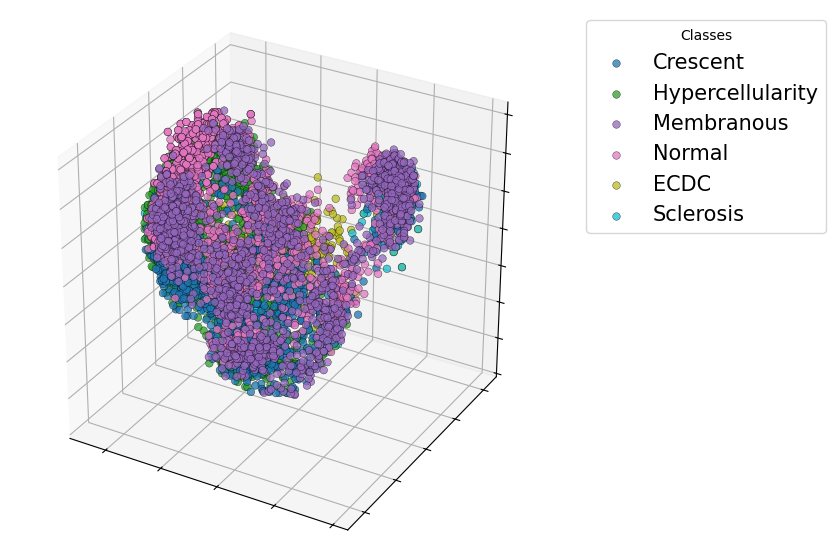

In [6]:

data = np.load("./../../local_experiments/retr_test_backone_glomerulo/uni_glomerulo_2025-06-29_20-03-18/embeddings_2025-06-29_20-06-02.npz", allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="glomerulo_uni_embedding_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)
# plot_embedding_umap(
#     db_embeddings=data["db_embeddings"],
#     db_labels_bin=data["db_labels"],
#     class_mapping=data["class_mapping"].item(),
#     query_embeddings=None,
#     dim=3,  # or 2
#     save_path="embedding_umap_3d.pdf"
# )

/tmp/ipykernel_40208/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_40208/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


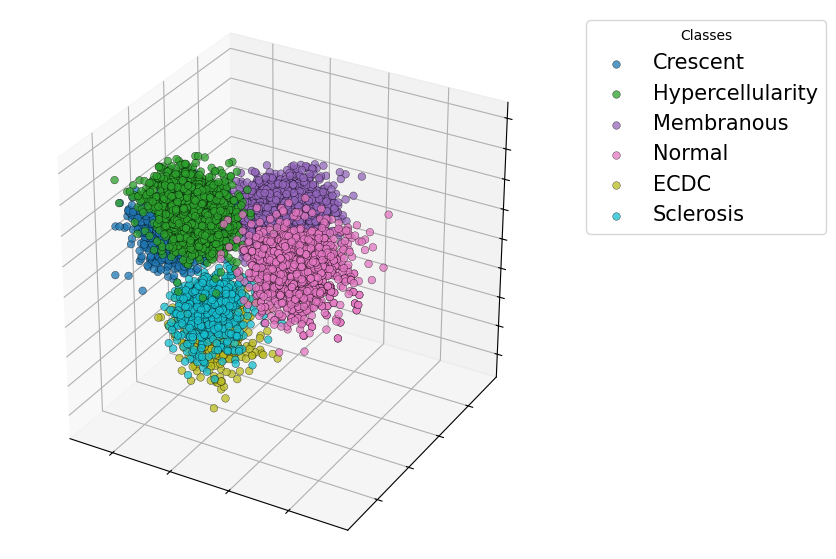

In [56]:

data = np.load("./glomerulo_embeddings_uni_fsl_embeddings_2025-04-20_15-19-51.npz", allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="glomerulo_uni_fsl_embedding_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)
# plot_embedding_umap(
#     db_embeddings=data["db_embeddings"],
#     db_labels_bin=data["db_labels"],
#     class_mapping=data["class_mapping"].item(),
#     query_embeddings=None,
#     dim=3,  # or 2
#     save_path="embedding_umap_3d.pdf"
# )

/tmp/ipykernel_40208/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_40208/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


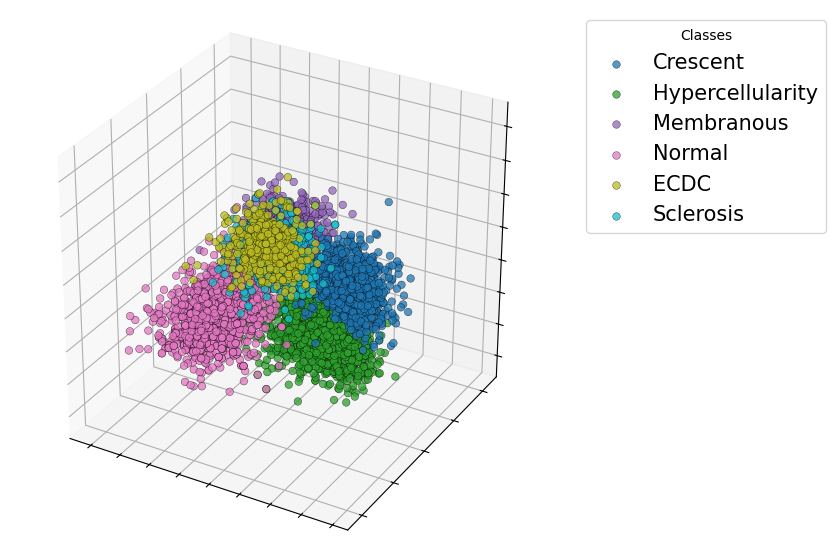

In [57]:
data = np.load("./../../local_experiments/retr_fsl_train_test_glomerulo/uni_fsl_glomerulo_2025-06-26_23-20-03/embeddings_2025-06-26_23-23-00.npz", allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="glomerulo_uni_fsl_embedding_pca_3d_v2.pdf",
    show_legend=True,
    legend_fontsize=15
)

/tmp/ipykernel_40208/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_40208/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


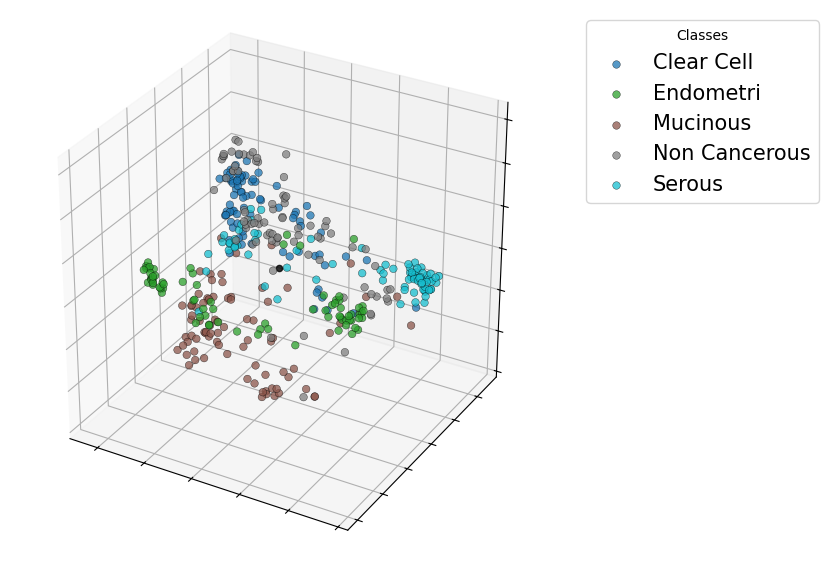

In [58]:
t = './ovarian-cancer-splitted_embeddings_UNI2-h_2025-05-29_13-42-40.npz'
data = np.load(t, allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="ovarian_splitted_embeddings_UNI2_h_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)

/tmp/ipykernel_40208/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_40208/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


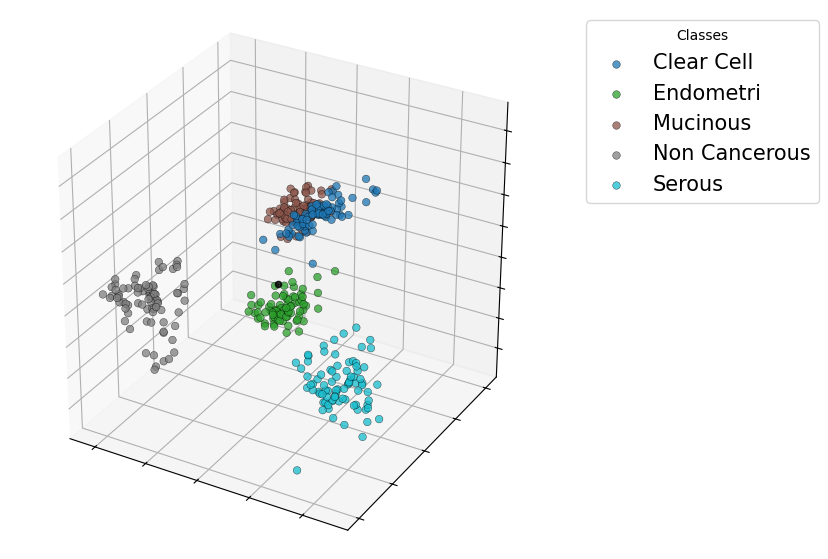

In [59]:
t = './../../local_experiments/retr_fsl_train_test_ovarian-cancer-splitted/UNI2-h_fsl_ovarian-cancer-splitted_2025-06-26_23-32-22/embeddings_2025-06-26_23-34-40.npz'
data = np.load(t, allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="ovarian_splitted_embeddings_UNI2_h_fsl_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)

/tmp/ipykernel_7989/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_7989/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


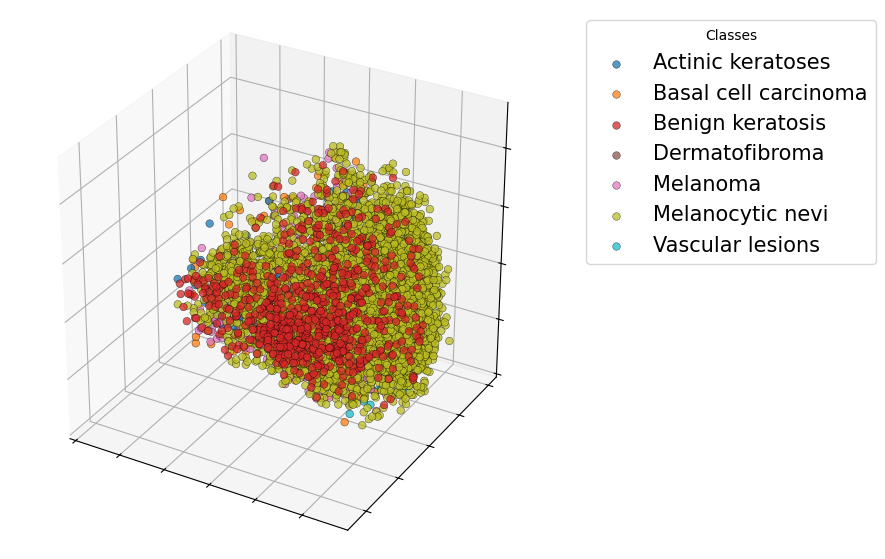

In [7]:
t = './../../local_experiments/retr_test_backone_skin-cancer-splitted/phikon-v2_skin-cancer-splitted_2025-06-29_20-06-12/embeddings_2025-06-29_20-15-22.npz'
data = np.load(t, allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="skin_cancer_pretreined_embeddings_phikon-v2_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)

/tmp/ipykernel_40208/377832321.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(np.unique(db_labels)))
/tmp/ipykernel_40208/377832321.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


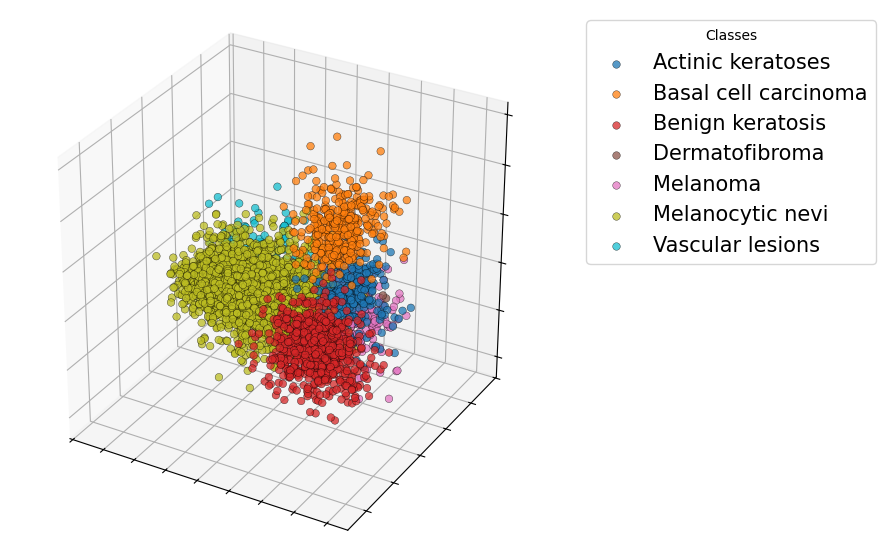

In [61]:
t = './../../local_experiments/retr_fsl_train_test_skin-cancer-splitted/phikon-v2_fsl_skin-cancer-splitted_2025-06-26_23-23-09/embeddings_2025-06-26_23-32-14.npz'

data = np.load(t, allow_pickle=True)

# plot_embedding_space(
plot_embedding_pca(
    db_embeddings=data["db_embeddings"],
    db_labels_bin=data["db_labels"],
    class_mapping=data["class_mapping"].item(),
    query_embeddings=None,
    dim=3,  # or 2
    save_path="skin_cancer_pretreined_embeddings_phikon-v2_fsl_pca_3d.pdf",
    show_legend=True,
    legend_fontsize=15
)